In [49]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit

import seaborn as sns
import matplotlib.pyplot as plt

## Modeling for product_80028349

In [41]:
PRODUCT_ID = 80028349
df = pd.read_csv('data/prepared_data/product_80028349.csv', index_col=0)
df.drop(['item_number', 'item_name'], axis=1, inplace=True)
df['day'] = pd.to_datetime(df['day'])

In [42]:
df.head()

,day,purchase_price,suggested_retail_price,orders_quantity,sales_quantity
0,2021-04-03,0.674928,1.055314,0.0,23.0
1,2021-04-04,0.674928,1.055314,0.0,0.0
2,2021-04-05,0.674928,1.055314,0.0,0.0
3,2021-04-06,0.610000,0.790000,0.0,26.0
4,2021-04-07,0.610000,0.790000,0.0,19.0


### Generate features

In [43]:
df['day_of_week'] = df.day.dt.day_of_week
df['is_weekend'] = df.day_of_week.apply(lambda x: 0 if x<5 else 1)
df['month'] = df.day.dt.month

df.set_index('day', inplace=True)

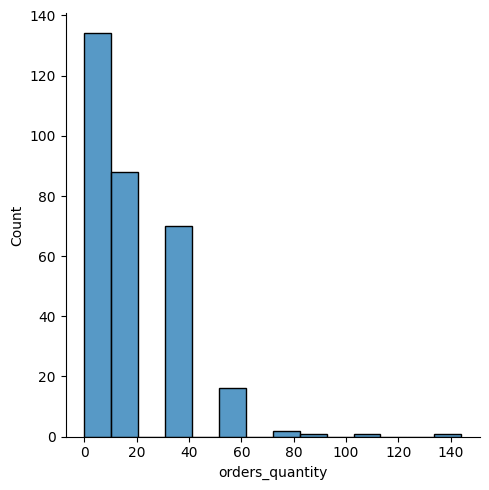

In [44]:
sns.displot(df.orders_quantity)

In [45]:
df.orders_quantity.unique()

array([  0.,  54.,  18.,  36., 108.,  90.,  72., 144.])

In [46]:
bins = [-1,0,20,40,100]
df['orders_quantity_binned'] = pd.cut(df['orders_quantity'], bins)
df.drop(['orders_quantity'], axis=1, inplace=True)

In [47]:
df.head()

,purchase_price,suggested_retail_price,sales_quantity,day_of_week,is_weekend,month,orders_quantity_binned
day,,,,,,,
2021-04-03,0.674928,1.055314,23.0,5,1,4,"(-1, 0]"
2021-04-04,0.674928,1.055314,0.0,6,1,4,"(-1, 0]"
2021-04-05,0.674928,1.055314,0.0,0,0,4,"(-1, 0]"
2021-04-06,0.610000,0.790000,26.0,1,0,4,"(-1, 0]"
2021-04-07,0.610000,0.790000,19.0,2,0,4,"(-1, 0]"


In [48]:
df.corr()

/var/folders/hj/_n28zpjd77v589mypbm9z1vr0000gn/T/ipykernel_84844/1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,purchase_price,suggested_retail_price,sales_quantity,day_of_week,is_weekend,month
purchase_price,1.000000,0.973049,-0.210442,-0.001578,0.000118,-0.003175
suggested_retail_price,0.973049,1.000000,-0.224269,-0.004688,-0.000829,0.014524
sales_quantity,-0.210442,-0.224269,1.000000,-0.111513,-0.269261,0.133181
day_of_week,-0.001578,-0.004688,-0.111513,1.000000,0.792909,-0.001847
is_weekend,0.000118,-0.000829,-0.269261,0.792909,1.000000,-0.021242
month,-0.003175,0.014524,0.133181,-0.001847,-0.021242,1.000000


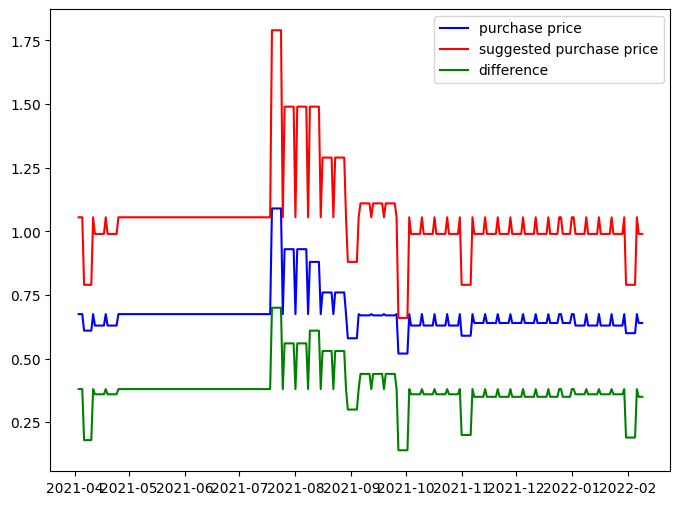

In [53]:
plt.figure(figsize=(8,6))
plt.plot(df['purchase_price'], 'b', label="purchase price")
plt.plot(df['suggested_retail_price'], 'r', label="suggested purchase price")
plt.plot(df['suggested_retail_price'] - df['purchase_price'], 'g', label="difference")
plt.legend()
plt.show()

In [54]:
df['price_diff'] = df['suggested_retail_price'] - df['purchase_price']
df.drop(['suggested_retail_price', 'purchase_price'], axis=1, inplace=True)

In [55]:
df.head()

,sales_quantity,day_of_week,is_weekend,month,orders_quantity_binned,price_diff
day,,,,,,
2021-04-03,23.0,5,1,4,"(-1, 0]",0.380386
2021-04-04,0.0,6,1,4,"(-1, 0]",0.380386
2021-04-05,0.0,0,0,4,"(-1, 0]",0.380386
2021-04-06,26.0,1,0,4,"(-1, 0]",0.180000
2021-04-07,19.0,2,0,4,"(-1, 0]",0.180000


/var/folders/hj/_n28zpjd77v589mypbm9z1vr0000gn/T/ipykernel_84844/262033593.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.price_diff)


<AxesSubplot: xlabel='price_diff', ylabel='Density'>

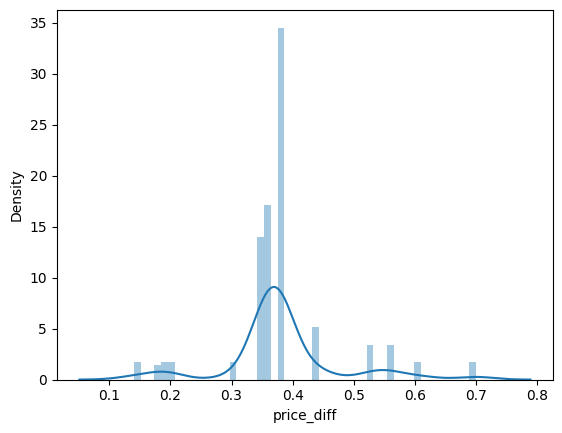

In [56]:
sns.distplot(df.price_diff)

,sales_quantity
month,
1,17.967742
2,19.555556
4,21.178571
5,18.387097
6,7.700000
7,6.290323
8,19.032258
9,19.466667
10,20.064516


In [73]:
def calculate_sales_features(train_df: pd.DataFrame):
    day_of_week_sales = df.groupby(['day_of_week'])[['sales_quantity']].mean()
    day_of_week_sales = day_of_week_sales.reset_index().rename(columns={'sales_quantity': 'dow_avg'})
    
    weekend_sales = df.groupby(['is_weekend'])[['sales_quantity']].mean()
    weekend_sales = weekend_sales.reset_index().rename(columns={'sales_quantity': 'wd_avg'})
    
    month_sales = df.groupby(['month'])[['sales_quantity']].mean()
    month_sales = month_sales.reset_index().rename(columns={'sales_quantity': 'month_avg'})
    
    return day_of_week_sales, weekend_sales, month_sales

In assumption that:
 1. Our forecast horizon is 1 day
 2. I'am already late for submission

We can use all possible lag features (we need only 1 day prediction)
I will use simple cross validation instead of time series split (I know it's not right, but I have to sacrifice something)

In [84]:
train_size = int(df.shape[0] * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

In [85]:
day_of_week_sales, weekend_sales, month_sales = calculate_sales_features(train_df)

In [86]:
train_df = pd.merge(train_df, day_of_week_sales, how='left', on='day_of_week')
train_df = pd.merge(train_df, weekend_sales, how='left', on='is_weekend')
train_df = pd.merge(train_df, month_sales, how='left', on='month')

for col in ['day_of_week', 'is_weekend', 'month']:
    train_df[col] = train_df[col].astype(str)

In [89]:
pd.get_dummies(train_df[['day_of_week', 'is_weekend', 'month']])

,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,is_weekend_0,is_weekend_1,month_10,month_11,month_12,month_4,month_5,month_6,month_7,month_8,month_9
0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0
246,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0
247,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
248,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
